In [1]:
!pip uninstall -y numpy
!pip install numpy
!pip install --force-reinstall gensim

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-c

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from gensim.utils import simple_preprocess
import gensim.downloader as api


In [4]:
# Charger les données
df= pd.read_csv("NikeProductDescriptions.csv")
subtitles_to_keep = [
    "Men's Shoes", "Men's T-Shirt", "Women's Shoes",
    "Skate Shoes", "Older Kids' T-Shirt"
]

df_filtered = df[df['Subtitle'].isin(subtitles_to_keep) |
                 df['Subtitle'].str.contains('Shorts', case=False, na=False)].copy()
df_filtered.loc[df_filtered['Subtitle'].str.contains('Shorts', case=False, na=False), 'Subtitle'] = 'Shorts'

print("Filtered Data Subtitles Distribution:")
print(df_filtered['Subtitle'].value_counts())

Filtered Data Subtitles Distribution:
Subtitle
Shorts                 45
Women's Shoes          34
Men's Shoes            31
Skate Shoes            22
Men's T-Shirt          14
Older Kids' T-Shirt     9
Name: count, dtype: int64


In [7]:
print(df_filtered.shape)
print(df_filtered.info())
print(df_filtered.describe())

(155, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 155 entries, 0 to 395
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                155 non-null    object
 1   Subtitle             155 non-null    object
 2   Product Description  155 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB
None
                  Title Subtitle  \
count               155      155   
unique              117        6   
top     Nike Sportswear   Shorts   
freq                 13       45   

                                      Product Description  
count                                                 155  
unique                                                155  
top     It doesn't get more legendary than this. Desig...  
freq                                                    1  


In [9]:
# ===== Méthode 1: Bag of Words =====
vectorizer_bow = CountVectorizer(stop_words='english')
X_bow = vectorizer_bow.fit_transform(df_filtered['Product Description'])
X_pca_bow = PCA(n_components=2).fit_transform(X_bow.toarray())

In [10]:
# ===== Méthode 2: TF-IDF =====
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer_tfidf.fit_transform(df_filtered['Product Description'])
X_pca_tfidf = PCA(n_components=2).fit_transform(X_tfidf.toarray())


In [12]:
# ===== Méthode 3: Word2Vec =====
w2v_model = api.load("word2vec-google-news-300")
def embed_w2v(text):
    words = simple_preprocess(text)
    vectors = [w2v_model[word] for word in words if word in w2v_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)
X_w2v = np.array([embed_w2v(text) for text in df_filtered['Product Description']])
X_pca_w2v = PCA(n_components=2).fit_transform(X_w2v)

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [14]:
# ===== Méthode 4: GloVe =====
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

glove_model = {}
glove_path = "glove.6B.100d.txt"  # Assure-toi que le fichier est bien ici
with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        glove_model[values[0]] = np.array(values[1:], dtype='float32')

def embed_glove(text):
    words = simple_preprocess(text)
    vectors = [glove_model[word] for word in words if word in glove_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)
X_glove = np.array([embed_glove(text) for text in df_filtered['Product Description']])
X_pca_glove = PCA(n_components=2).fit_transform(X_glove)

--2025-05-09 15:51:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-09 15:51:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-09 15:51:03--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

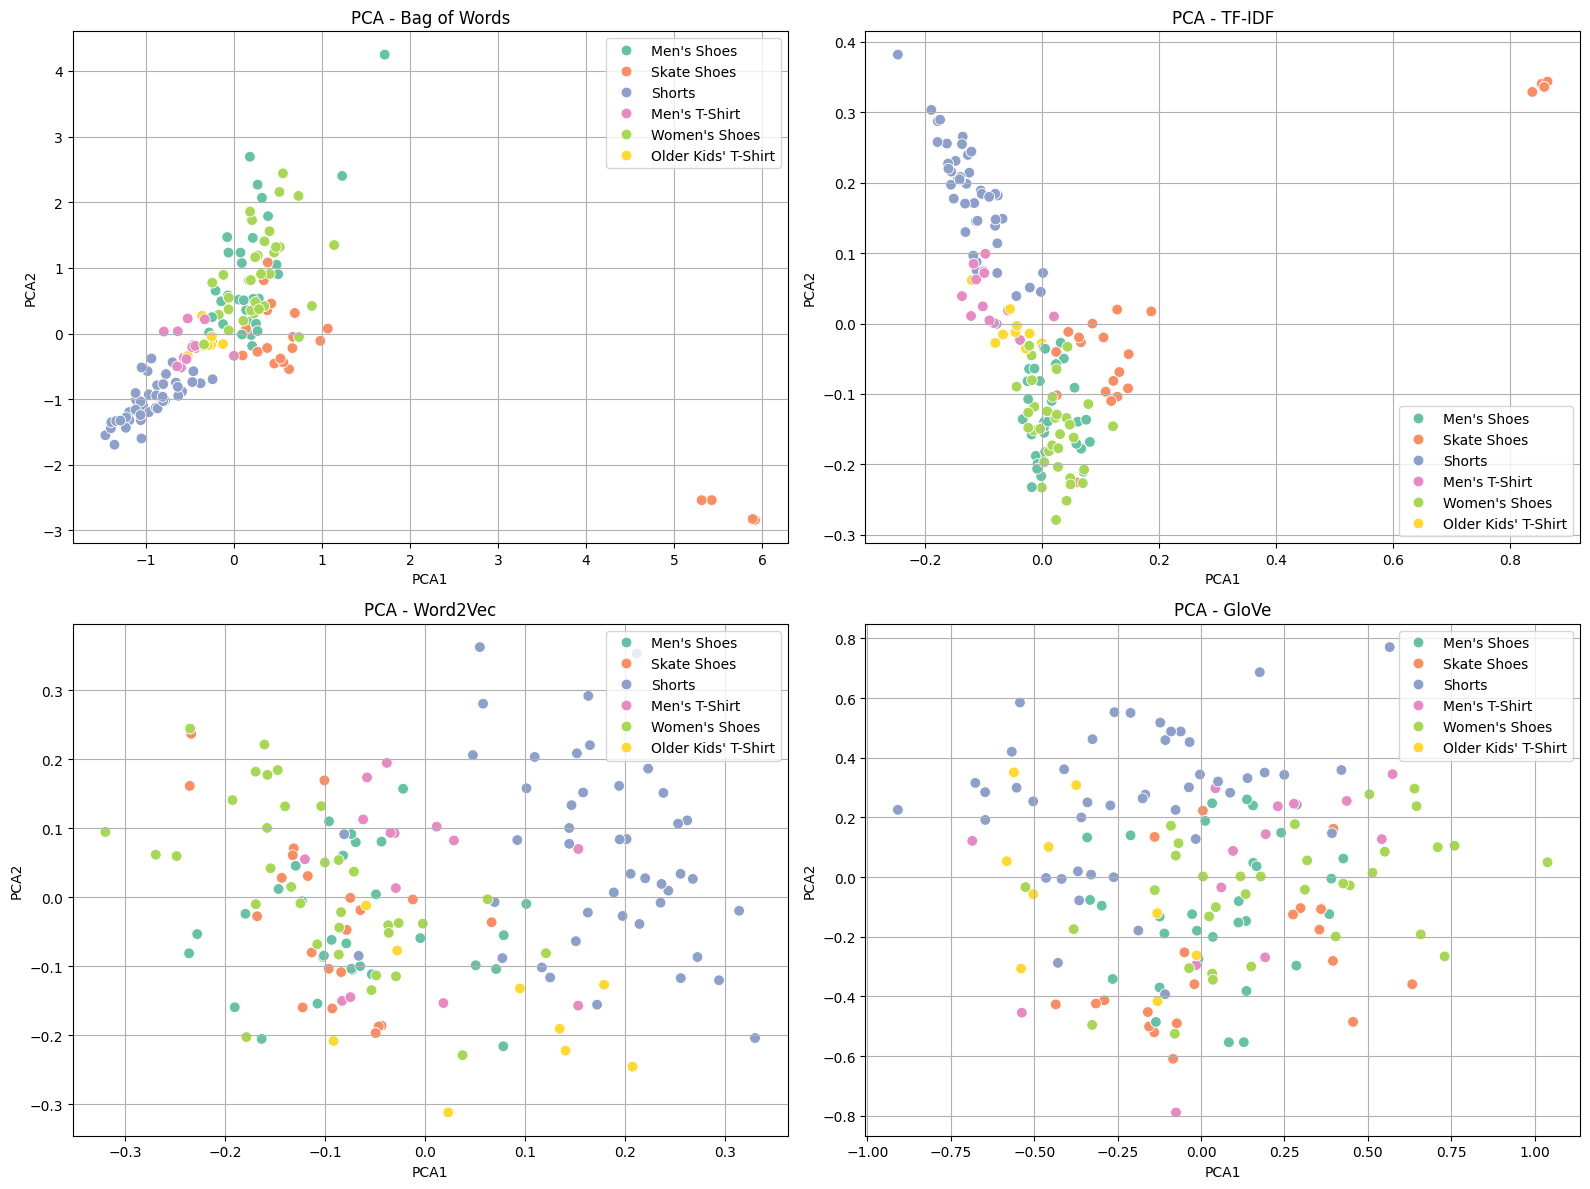

In [16]:
# ===== Visualisation =====
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
methods = ['Bag of Words', 'TF-IDF', 'Word2Vec', 'GloVe']
pca_results = [X_pca_bow, X_pca_tfidf, X_pca_w2v, X_pca_glove]

for ax, method, result in zip(axes.flat, methods, pca_results):
    df_plot = pd.DataFrame({
        'PCA1': result[:, 0],
        'PCA2': result[:, 1],
        'Subtitle': df_filtered['Subtitle']
    })
    sns.scatterplot(data=df_plot, x='PCA1', y='PCA2', hue='Subtitle', ax=ax, palette='Set2', s=60)
    ax.set_title(f"PCA - {method}")
    ax.grid(True)
    ax.legend().set_title(None)

plt.tight_layout()
plt.show()

The PCA plots show that text representation greatly impacts how categories are separated.

The Bag of Words model shows decent clustering—especially for "Men's Shoes" and "Skate Shoes"—but has some outliers. TF-IDF gives clearer separation overall, though it still isolates some rare cases like "Skate Shoes."

Word2Vec spreads the data more evenly, with less separation, suggesting it captures broader semantic patterns. GloVe is the most scattered, likely due to its focus on global co-occurrence, making clusters harder to identify.

In short, TF-IDF offers the best separation for classification, while Word2Vec and GloVe are better suited for capturing similarity. Bag of Words is simple but still effective.